### Explanation

In the shorter paper, a hydrodynamical account to explain why microorganisms cluster at the boundaries is given. This starts by modelling E. coli bacteria as "force dipoles", 2 single point forces separated by some distance that exert forces in opposite directions. The equation used to describe the fluid velocity around this system is as such:

$\textbf{u} = \frac{p}{8\pi \eta r^3}(-1 + 3 \frac{(\textbf{r} \cdot \textbf{e})^2}{r^3})\textbf{r}$

where $\textbf{e}$ is swimming direction, $\eta$ is fluid velocity and $\textbf{r}$ is distance from the dipole

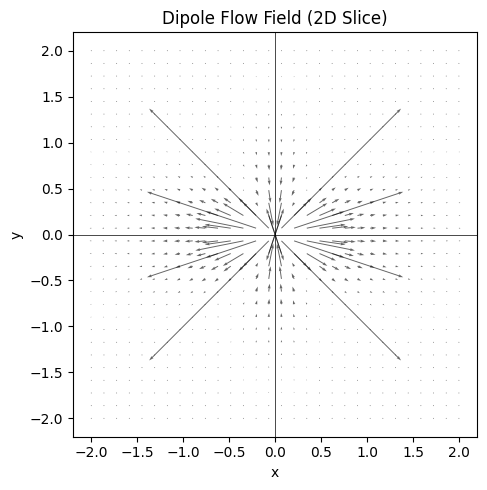

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Parameters
p = 1.0       # dipole strength
eta = 1.0     # viscosity
e = np.array([1.0, 0.0])  # swimming direction (unit vector, x-axis)

# Grid
nx, ny = 30, 30  # number of points in x and y directions
x_vals = np.linspace(-2, 2, nx)
y_vals = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# Allocate arrays for velocity components
U = np.zeros_like(X)
V = np.zeros_like(Y)

# Compute the velocity field
for i in range(nx):
    for j in range(ny):
        x = X[j, i]
        y = Y[j, i]
        
        # Radius in 2D
        r = np.sqrt(x*x + y*y)
        
        # Avoid the singularity at r = 0
        if r > 1e-6:
            # Dot product r·e = x (since e = (1,0))
            r_dot_e = x
            
            # Dipole factor in brackets: [-1 + 3 (r·e)^2 / r^2]
            bracket = -1 + 3.0*(r_dot_e**2)/(r*r)
            
            # Full prefactor for 3D dipole  ~ p / (8 pi eta r^3)
            prefactor = p / (8.0 * np.pi * eta * (r**3))
            
            # Velocity components:  (prefactor * bracket) * (x, y)
            U[j, i] = prefactor * bracket * x
            V[j, i] = prefactor * bracket * y
        else:
            U[j, i] = 0.0
            V[j, i] = 0.0

# Plotting
plt.figure(figsize=(6, 5))
plt.title("Dipole Flow Field (2D Slice)")

# Quiver (vector) plot
plt.quiver(X, Y, U, V, color='black', alpha=0.6, scale=5)

# Streamplot (optional), for a smoother flow visualization
# Can overlay or use instead of quiver
# plt.streamplot(X, Y, U, V, color='black', density=1.0, linewidth=1)

plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()


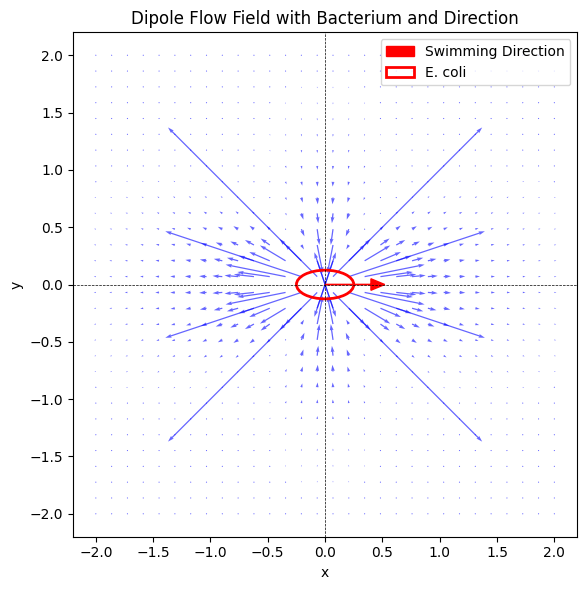

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
p = 1.0       
eta = 1.0    
e = np.array([1.0, 0.0])  # swimming direction (unit vector, x-axis)

# Grid setup
nx, ny = 30, 30 
x_vals = np.linspace(-2, 2, nx)
y_vals = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# Allocate arrays for velocity components
U = np.zeros_like(X)
V = np.zeros_like(Y)

# Compute the velocity field
for i in range(nx):
    for j in range(ny):
        x = X[j, i]
        y = Y[j, i]
        
        # Radius in 2D
        r = np.sqrt(x*x + y*y)
        
        # Avoid the singularity at r = 0
        if r > 1e-6:
            # Dot product r·e = x (since e = (1,0))
            r_dot_e = x
            
            # Dipole factor in brackets: [-1 + 3 (r·e)^2 / r^2]
            bracket = -1 + 3.0*(r_dot_e**2)/(r*r)
            
            # Full prefactor for 3D dipole  ~ p / (8 pi eta r^3)
            prefactor = p / (8.0 * np.pi * eta * (r**3))
            
            # Velocity components:  (prefactor * bracket) * (x, y)
            U[j, i] = prefactor * bracket * x
            V[j, i] = prefactor * bracket * y
        else:
            U[j, i] = 0.0
            V[j, i] = 0.0

# Plot
plt.figure(figsize=(7, 6))
plt.title("Dipole Flow Field with Bacterium and Direction")

# Quiver plot
plt.quiver(X, Y, U, V, color='blue', alpha=0.6, scale=5, width=0.0025)

# Add bacteria
bacterium = Ellipse(xy=(0, 0), width=0.5, height=0.25, 
                        edgecolor='r', fc='None', lw=2, label="E. coli")
plt.arrow(0, 0, 0.4, 0, head_width=0.1, head_length=0.12, fc='red', ec='red', label='Swimming Direction')

plt.gca().add_patch(bacterium)


plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='k', linewidth=0.5, linestyle='--')
plt.axvline(0, color='k', linewidth=0.5, linestyle='--')
plt.gca().set_aspect('equal', 'box')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()


The article then goes on to say that near a wall, the flow field induced by the bacteria is a superposition of that due to the force dipole, plus any image flow field located on the other side of the boundary, necessary to enforce the boundary condition. I believe that in this case, the boundary condition we are enforcing is the "no slip" boundary condition, i.e. that the velocity at the boundary should be 0 - a Dirichlet boundary condition. I'm now going to try and plot the field conditions when we consider also the image system.

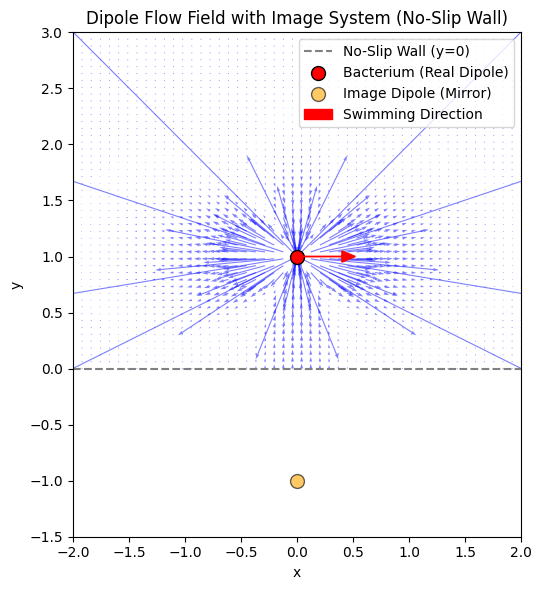

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters 
p = 1.0       # dipole strength
eta = 1.0     # viscosity
y0 = 1.0      # distance of bacterium from wall
e = np.array([1.0, 0.0])  # swimming direction (unit vector along x-axis)

# Grid setup
nx, ny = 50, 50  # grid resolution
x_vals = np.linspace(-2, 2, nx)
y_vals = np.linspace(0, 3, ny)  # Above the wall (y=0)
X, Y = np.meshgrid(x_vals, y_vals)

# Allocate arrays for velocity components
U = np.zeros_like(X)
V = np.zeros_like(Y)

# Function to compute dipole velocity field
def dipole_velocity(x, y, x0, y0, p, eta):
    """Compute velocity from a dipole located at (x0, y0)."""
    dx = x - x0
    dy = y - y0
    r2 = dx**2 + dy**2
    r = np.sqrt(r2)
    
    if r < 1e-6:
        return 0.0, 0.0  # Avoid singularity
    
    # Dipole formula for 3D far-field
    r_dot_e = dx  # since e = (1, 0)
    bracket = -1 + 3 * (r_dot_e**2) / r2
    prefactor = p / (8.0 * np.pi * eta * r**3)
    
    ux = prefactor * bracket * dx
    uy = prefactor * bracket * dy
    
    return ux, uy

# Compute combined field (Real + Image) 
for i in range(nx):
    for j in range(ny):
        x = X[j, i]
        y = Y[j, i]
        
        # Real dipole (above wall)
        ux_r, uy_r = dipole_velocity(x, y, 0, y0, p, eta)
        
        # Image dipole (below wall, opposite orientation)
        ux_i, uy_i = dipole_velocity(x, y, 0, -y0, -p, eta)  # opposite sign for image
        
        # Superpose real and image fields
        U[j, i] = ux_r + ux_i
        V[j, i] = uy_r + uy_i

# Plotting
plt.figure(figsize=(7, 6))
plt.title("Dipole Flow Field with Image System (No-Slip Wall)")

# Wall line
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, label='No-Slip Wall (y=0)')

# Quiver (vector field)
plt.quiver(X, Y, U, V, color='blue', alpha=0.5, scale=7, width=0.0025)


# Bacterium (real dipole)
plt.scatter(0, y0, color='red', s=100, label='Bacterium (Real Dipole)', edgecolors='black')

# Image Dipole
plt.scatter(0, -y0, color='orange', s=100, label='Image Dipole (Mirror)', edgecolors='black', alpha=0.6)

# Arrow to indicate swiming direction
plt.arrow(0, 1, 0.4, 0, head_width=0.1, head_length=0.12, fc='red', ec='red', label='Swimming Direction')

# --- Labels and Legend ---
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2, 2)
plt.ylim(-1.5, 3)
plt.gca().set_aspect('equal', 'box')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()


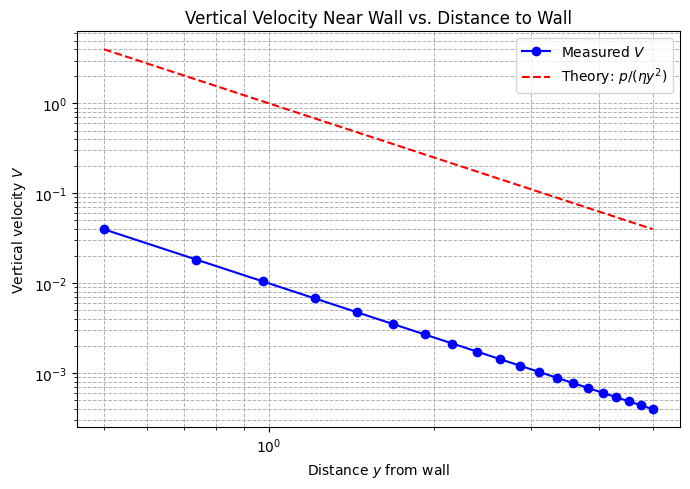

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
p = 1.0       # dipole strength
eta = 1.0     # viscosity
e = np.array([1.0, 0.0])  # swimming direction (unit vector)

# Function to compute dipole velocity field
def dipole_velocity(x, y, x0, y0, p, eta):
    """Compute velocity from a dipole located at (x0, y0)."""
    dx = x - x0
    dy = y - y0
    r2 = dx**2 + dy**2
    r = np.sqrt(r2)
    
    if r < 1e-6:
        return 0.0, 0.0  # Avoid singularity
    
    
    r_dot_e = dx  # since e = (1, 0)
    bracket = -1 + 3 * (r_dot_e**2) / r2
    prefactor = p / (8.0 * np.pi * eta * r**3)
    
    ux = prefactor * bracket * dx
    uy = prefactor * bracket * dy
    
    return ux, uy

# Measure Vertical Velocity at Different Distances
y_vals = np.linspace(0.5, 5, 20)  # Distances from the wall
vertical_velocities = []

for y0 in y_vals:
    # Real dipole
    ux_r, uy_r = dipole_velocity(0, y0, 0, y0, p, eta)
    
    # Image dipole (opposite sign, mirrored below the wall)
    ux_i, uy_i = dipole_velocity(0, y0, 0, -y0, -p, eta)
    
    # Combined vertical velocity
    vertical_velocities.append(uy_r + uy_i)

# Plot Results
plt.figure(figsize=(7, 5))
plt.title("Vertical Velocity Near Wall vs. Distance to Wall")

# Plot measured vertical velocity
plt.plot(y_vals, vertical_velocities, 'bo-', label='Measured $V$')

# Plot theoretical scaling p/(eta*y^2)
theory = p / (eta * y_vals**2)
plt.plot(y_vals, theory, 'r--', label=r'Theory: $p/(\eta y^2)$')

plt.xlabel(r'Distance $y$ from wall')
plt.ylabel(r'Vertical velocity $V$')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", linestyle='--', linewidth=0.7)
plt.legend(loc='best')

plt.tight_layout()
plt.show()

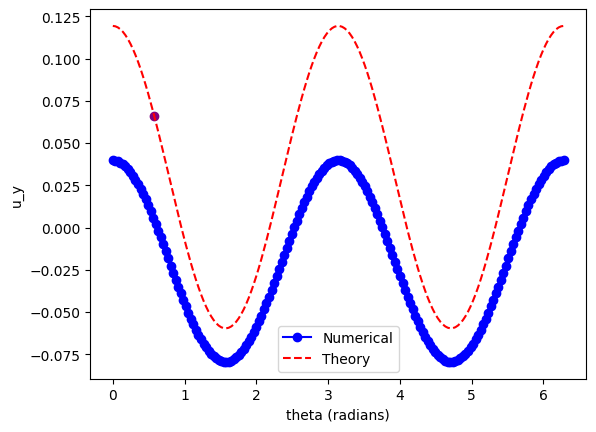

In [40]:
p = 1.0
eta = 1.0
y0 = 0.5  # distance from wall

# Vary theta from 0 to 360 degrees
thetas = np.linspace(0, 2*np.pi, 180)
uys = []

def dipole_velocity(x, y, x0, y0, e, p, eta):
    dx = x - x0
    dy = y - y0
    r2 = dx*dx + dy*dy
    r = np.sqrt(r2)
    if r < 1e-9:
        return 0,0
    # dot(r,e)
    re_dot = dx*e[0] + dy*e[1]
    bracket = -1 + 3*(re_dot**2)/r2
    prefactor = p/(8*np.pi*eta*r**3)
    ux = prefactor*bracket*dx
    uy = prefactor*bracket*dy
    return ux, uy

for th in thetas:

    e = ( np.cos(th), np.sin(th) )
    
    # Real dipole at (0,y0)
    ux_r, uy_r = dipole_velocity(0, y0, 0, y0, e, p, eta)
    
    # Image dipole at (0,-y0), sign -p
    ux_i, uy_i = dipole_velocity(0, y0, 0, -y0, e, -p, eta)
    
    # sum 
    uy_total = uy_r + uy_i
    uys.append(uy_total)

# Compare with the formula -3p/(64 pi eta y^2) * (1-3cos^2(theta))
theory = []
for th in thetas:
    val = -3*p/(64*np.pi*eta*(y0**2))*(1 - 3*np.cos(th)**2) 
    theory.append(val)

plt.plot(thetas, uys, 'bo-', label='Numerical')
plt.plot(thetas, theory, 'r--', label='Theory')
plt.xlabel('theta (radians)')
plt.ylabel('u_y')
scatter_angle = 1/np.sqrt(3)
scatter_point = -3*p/(64*np.pi*eta*(y0**2))*(1 - 3*np.cos(scatter_angle)**2)
plt.scatter(scatter_angle, scatter_point, color='purple')
plt.legend()
plt.show()
